# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import math
import pandas as pd

### Открытие файла и изучение общей информации. 

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') #уточнение символа разделения
df

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,NaN,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


**Промежуточный вывод** таблица содержит информацию об объявлениях недвижимости. В одной строке достаточно много столбцов и не все они заполнены, нужно это проанализировать. Сразу бросается в глаз формат даты, надо его сделать читабельным для программы. В таблице по мимо уникальных значений существуют булевые значения и текстовая запись

### Предобработка данных
Общая информация о файле

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В таблице 22 столбеца. Тип данных в столбцах  — `object`, `bool`, `float64`, `int64`. Количество значений в столбцах не одинаковое, следовательно в данных есть пропущенные значения.
В документе 23699 строк.

Согласно документации столбцы называться:
*   `total_images` - число фотографий квартиры в объявлении;
*   `last_price` — цена на момент снятия с публикации;
*   `total_area` — общая площадь квартиры в квадратных метрах (м²);
*   `first_day_exposition` — дата публикации;
*   `rooms` — число комнат;
*   `ceiling_height` — высота потолков (м);
*   `floors_total` — всего этажей в доме;
*   `living_area` — жилая площадь в квадратных метрах (м²);
*   `floor` — этаж;
*   `is_apartment` — апартаменты (булев тип);
*   `studio` — квартира-студия (булев тип);
*   `open_plan` — свободная планировка (булев тип);
*   `kitchen_area` — площадь кухни в квадратных метрах (м²);
*   `balcony` — число балконов;
*   `locality_name` — название населённого пункта;
*   `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м);
*   `cityCenters_nearest` — расстояние до центра города (м);
*   `parks_around3000` — число парков в радиусе 3 км;
*   `parks_nearest` — расстояние до ближайшего парка (м);
*   `ponds_around3000` — число водоёмов в радиусе 3 км;
*   `ponds_nearest` — расстояние до ближайшего водоёма (м);
*   `days_exposition` — сколько дней было размещено объявление (от публикации до снятия);

**Подсчет пропусков в столбцах:**

In [4]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Единый стиль названия столбцов**

Название столбцов не все отображены в змеином стиле, исправляем:

In [5]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [6]:
df = (df.rename(columns={'cityCenters_nearest':'city_centers_nearest',
                         'parks_around3000':'parks_around_3000', 
                         'ponds_around3000':'ponds_around_3000'}))
df.columns#контрольная проверка

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

**Анализ непрерывных значений**

In [7]:
df.describe() #общее представление о данных

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


**Заполнение и аргументация пропущенных значений:** 
1.   floors_total
1.   locality_name
2.   city_centers_nearest3
3.   parks_nearest 
4.   ponds_nearest 
5. ceiling_height
*    days_exposition


**Пропущенные значения `floors_total`** 
Столбец стоит отчистить от пропусков, чтобы потом не было проблем с постороением графиков.

In [8]:
df = df.dropna(subset=['floors_total']) 
#заполнение средним значением кол-во этажей, в дальнейшем это значение нам понадобится

**Столбец `locality_name` содержит пропуски.**

Данный параметр достаточно важный, от места расположения недвижимости напрямую зависит цена. Пропусков содержится не так много поэтому их можно спокойно удалить из таблицы и это не отразиться на общей картине данных

In [9]:
#удаляем строки из столбца с отсутствующеми значениями 
df = df.dropna(subset=['locality_name']) 

**Пропуски в столбце `city_centers_nearest`**

В данном столбце тоже необходимо обработать пропуски, т.к. в дальнейшем нам понадобиться расстояние до центра города. "+" группа пропусков достаточно немаленькая.

In [10]:
df[(df['city_centers_nearest'].isna()==True)].head() #визуально оцениваем пропуски в других столбцах

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,NaN,5.0,30.00,5,NaN,...,9.00,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.00,15,NaN,...,11.00,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,NaN,9.0,NaN,2,NaN,...,NaN,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0


In [11]:
df = df.dropna(subset=['city_centers_nearest']).reset_index(drop=True) #удаляем пустые строки, обновление индексов

**Вывод:**
как мы видим пропуски есть не только в `city_centers_nearest` но и в других уточняющих группах уточняющих окружающую инфраструктуру объекта недвижимости. Эти данные я удалил.

**Заполнение количество `parks_nearest` и `ponds_nearest`**

Если в радиусе 3000 м нет указанного объекта, то `NaN` заменяем на 0.

In [12]:
#выявление пропусков и заполнение 0
df['parks_nearest'] = df['parks_nearest'].fillna(0)
df['ponds_nearest'] = df['ponds_nearest'].fillna(0)

#df[(df['ponds_nearest'].isna()==True) & (df['ponds_around_3000']==0)]

Заполнение пропусков в столбце `ceiling_height` медтаной.

In [13]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

**Вывод:** Не все столбцы будут необходимы в дальнейшем, поэтому нет смысла заполнять все досконально.

### **Аномалии и не корректные данные**

В столбце `rooms` не может быть ноль. 

In [14]:
df = df.query('rooms != 0') #исключаем из таблицы 

`ceiling_height` значения > 8 не могут быть.

хотел разделить значения > 8 на 10 чтобы сохранить значения, но не хватило понимания как можно потом сохранить имеющиеся значение среди тех значений которые не выполняют условие. Поэтому просто удалил

In [15]:
df = df[(df['ceiling_height'] < 8)|(df['ceiling_height'].isna()==True)]

`day_publication` удаляем те значения, где нет значений, потому что в данных указаны объявления о закрытых сделках




In [16]:
df = df.dropna(subset=['days_exposition']).reset_index(drop=True)

In [17]:
df.isna().sum()#результат после всех манипуляций

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1114
floor                       0
is_apartment            13707
studio                      0
open_plan                   0
kitchen_area             1259
balcony                  7155
locality_name               0
airports_nearest           22
city_centers_nearest        0
parks_around_3000           0
parks_nearest               0
ponds_around_3000           0
ponds_nearest               0
days_exposition             0
dtype: int64

**Заключение** 

Причиной пропусков в таблице могут быть по 2 причинам. Механические: не рассчитанное расстояние до аэропорта или рассчитано но в определенном радиусе нет подходящего объекта выведено «Nan», а не «0». Это относиться и к паркам, водоемам.
    
Второй тип пропусков, это если человек указал не корректно данные или вовсе не указала. Например, если пользователь не указан населенный пункт, то и расчет других вытекающих параметров в программе не произошел. Например расстояние до центра.

**Изменение типа данных в столбцах**

`last_price` в данном столбце стоит избавить от лишних знаков чтобы не был загруженный

In [18]:
#округление цены до целого числа
df['last_price'] = df['last_price'].astype(int) 

Так же `floors_total` приводим к целому числу чтобы не загружать таблицу

In [19]:
#этаж может быть только натуральным числом, избавляемся от лишних 0
df['floors_total'] = df['floors_total'].astype(int) 

`is_apartment` указан в документации как булев bool, на деле object.

In [20]:
df['is_apartment'] = df['is_apartment'].fillna(False)

**поиск не явных дубликатов в названиях населенного пункта**

(явные дубликаты в таблице отсутствуют)

В каких городах размещались когда либо объявления:

In [21]:
#сортируем по алфавиту
df['locality_name'].sort_values().unique() 

array(['Зеленогорск', 'Колпино', 'Красное Село', 'Кронштадт', 'Ломоносов',
       'Павловск', 'Петергоф', 'Пушкин', 'Санкт-Петербург', 'Сестрорецк',
       'поселок Лисий Нос', 'посёлок Александровская',
       'посёлок Белоостров', 'посёлок Левашово', 'посёлок Лисий Нос',
       'посёлок Металлострой', 'посёлок Молодёжное', 'посёлок Парголово',
       'посёлок Песочный', 'посёлок Понтонный', 'посёлок Репино',
       'посёлок Сапёрный', 'посёлок Стрельна', 'посёлок Усть-Ижора',
       'посёлок Шушары'], dtype=object)

Приводим к одному названию дублирующиеся названию `поселок Лисий Нос`

In [22]:
df['locality_name'] = df['locality_name'].replace(['поселок Лисий Нос'], 'посёлок Лисий Нос')


**Вывод** были обнаружены:
нарушения в стиле заголовков,
пропущенные значения, 
не верный тип данных,
неявные дубликаты

В данном разделе, в данных стало меньше нулей, которые разгрузили таблицу. Исправил тип данных столбцов, чтобы было комфортней в дальнейшем с ними работать. Удалил не явные дубликаты локаций и убрали аномалию с комнатами.

### Посчитайте и добавьте в таблицу новые столбцы

**Расчет цены одного квадратного метра квартиры**

Удаляем излишне завышенные или излишне заниженные значения

In [23]:
df = df[(100000<df['last_price'])&(500000000>df['last_price'])].reset_index(drop=True)

Чтобы рассчитать цену квадратного метра, нужно `last_price` разделить `total_area`

In [24]:
df['price_area'] = (df['last_price']/df['total_area']).round(1) #результат округляем до десятых
df[['last_price', 'total_area', 'price_area']].sort_values('price_area')

,last_price,total_area,price_area
11800,1800000,117.3,15345.3
13222,2200000,138.7,15861.6
14092,3200000,190.0,16842.1
15428,1600000,92.0,17391.3
2805,1200000,49.1,24439.9
...,...,...,...
11053,122000000,145.0,841379.3
10926,245000000,285.7,857542.9
3296,124000000,124.5,995983.9
9730,401300000,401.0,1000748.1


**Вывод** самый дешевый м2 стоит чуть больше 15 000, а самый дорогой достигает 1,7 млн. В принципе полученные значения больше 1 млн. можно считать выбросами и в будущем откинуть их. 

**Добавление столбца с днем публикации, месяцем и годом**

В первую очередь нужно в каком формате указана дата и расшифровать ее.

In [25]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

df['week_day'] = df['first_day_exposition'].dt.weekday #День недели 

df['day'] = df['first_day_exposition'].dt.day # день 

df['month'] = df['first_day_exposition'].dt.month # месяц

df['year'] = df['first_day_exposition'].dt.year  # год 

**Добавление столбца с типом этажа и квартиры**

In [26]:
def floor_df(type):
  floor = type['floor']
  level = type['floors_total']

  if floor == 1:
    return 'первый'
  
  elif floor == level:
    return 'последний'
  
  else:
    return 'другой'

In [27]:
df['floor_type'] = df.apply(floor_df, axis=1)

In [28]:
df['floor_type'].value_counts()

другой       11941
последний     1999
первый        1691
Name: floor_type, dtype: int64

**Вывод** квартиры в большинстве своем продаются на промежуточных этажах, нежели чем на крайних. 

### **Расстояние в км до центра города**

Надо перевести `city_centers_nearest` из метров в километры. Разделим столбец на `1000`


In [29]:
df['city_centers_nearest_km'] = df['city_centers_nearest']/1000
df['city_centers_nearest_km'] = df['city_centers_nearest_km'].round(0)

**Вывод** все те значения, которые меньше 1 относятся к объявлениям из центра Санкт-Петербурга. Так что за отправную точку взят центр Петера.

## Проведение исследовательского анализа данных

In [30]:
data = df[['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 
           'ceiling_height', 'floor', 'floor_type', 'floors_total', 'city_centers_nearest', 
           'airports_nearest', 'parks_nearest', 'week_day', 'month']]
print (data.isna().sum()) 
data.describe()

total_area                 0
living_area             1114
kitchen_area            1258
last_price                 0
rooms                      0
ceiling_height             0
floor                      0
floor_type                 0
floors_total               0
city_centers_nearest       0
airports_nearest          22
parks_nearest              0
week_day                   0
month                      0
dtype: int64


,total_area,living_area,kitchen_area,last_price,rooms,ceiling_height,floor,floors_total,city_centers_nearest,airports_nearest,parks_nearest,week_day,month
count,15631.000000,14517.000000,14373.000000,1.563100e+04,15631.000000,15631.000000,15631.000000,15631.000000,15631.000000,15609.000000,15631.000000,15631.000000,15631.000000
mean,61.768871,35.143525,10.745487,7.178331e+06,2.104344,2.712587,6.163841,11.245090,14303.418015,28875.316292,215.019513,2.578082,6.587039
std,36.871525,22.945599,6.081097,1.057288e+07,1.087320,0.226038,4.951146,6.554628,8584.782992,12708.674642,333.713605,1.776949,3.469521
min,12.000000,2.000000,2.000000,1.190000e+06,1.000000,1.000000,1.000000,1.000000,208.000000,0.000000,0.000000,0.000000,1.000000
25%,41.000000,19.000000,7.000000,3.950000e+06,1.000000,2.600000,3.000000,5.000000,9479.000000,18498.000000,0.000000,1.000000,3.000000
50%,53.000000,30.400000,9.500000,5.100000e+06,2.000000,2.670000,5.000000,9.000000,13163.000000,26819.000000,0.000000,3.000000,7.000000
75%,71.000000,42.900000,12.000000,7.300000e+06,3.000000,2.700000,8.000000,16.000000,16377.000000,37407.000000,408.000000,4.000000,10.000000
max,900.000000,409.700000,112.000000,4.200000e+08,19.000000,6.000000,33.000000,60.000000,65968.000000,84869.000000,3190.000000,6.000000,12.000000


**Вывод** не все столбцы заполняют в объявлениях поэтому в некоторых столбцах содержаться пропуски. Но в основных столбцах, где казана площадь, цена, этаж. Данная таблица содержит основные параметры, которые необходимо знать для цены образования

***Построение гистограмм по данным из таблицы***

<AxesSubplot:title={'center':'Площадь квартир'}, ylabel='Frequency'>

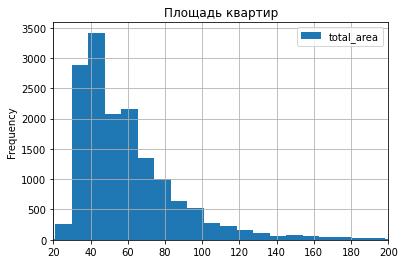

In [31]:
data.plot(title='Площадь квартир',
          kind='hist', 
          y='total_area',
          bins=100,
          grid=True,
          xlim=(20,200))

**Вывод:** Меньше 30 можно считать выбросами. В основном продаются квартиры площадью от 30, до 75 м2. Все квартиры с большей площадью встречаются гораздо реже на рынке и чем больше площадь тем меньше объявлений

<AxesSubplot:title={'center':'Жилая площадь'}, ylabel='Frequency'>

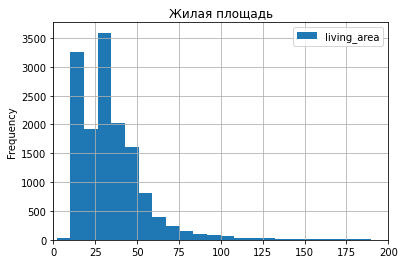

In [32]:
data.plot(title='Жилая площадь',
          kind='hist', 
          y='living_area',
          bins=50,
          grid=True,
          xlim=(0,200)
          )

**Вывод:** Стоит уточнить что не во всех объявлениях указывают жилую площадь => объем данных чуть меньше (1114).

Но все равно это не мешает увидеть два пика на графике, скорее всего это может быть связано с различными ценовыми категориями. Все значения ниже 10 м2 можно откидывать это выбросы. 

<AxesSubplot:title={'center':'Кухонная площадь'}, ylabel='Frequency'>

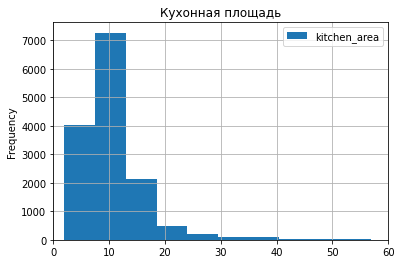

In [33]:
data.plot(title='Кухонная площадь',
          kind='hist', 
          y='kitchen_area',
          bins=20,
          grid=True,
          xlim=(0,60))

**Вывод:** В основном кухонная площадь имеет площадь меньше 20 м2. Не во всех объявлениях указывают размер кухонной зоны.   

<AxesSubplot:title={'center':'Цена'}, ylabel='Frequency'>

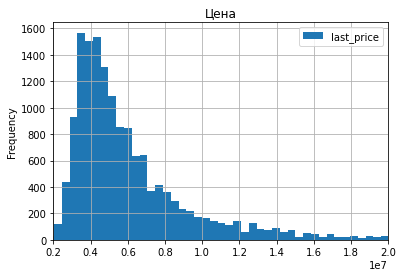

In [34]:
data.plot(title='Цена',
          kind='hist', 
          y='last_price',
          bins=1000,
          grid=True,
          xlim=(2e6,2e7))

**Вывод** Основная ценовая категория расположена в 3 000 000 - 6 000 000. Цены квартир выше 10 млн. уже более редкие, это видно на графике появляется больше шума ну и количество такого рода объявлений меньше.

<AxesSubplot:title={'center':'Комнаты'}, ylabel='Frequency'>

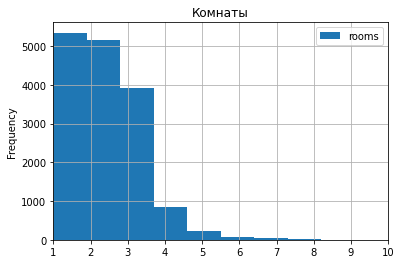

In [35]:
data.plot(title='Комнаты',
          kind='hist', 
          y='rooms',
          bins=20,
          grid=True,
          xlim=(1,10))

**Вывод** По графику видно, что самый распространённый типаж квартир это 1-3 комнатные квартиры. Все что больше это уже экзотика 

<AxesSubplot:title={'center':'высота потолков'}, ylabel='Frequency'>

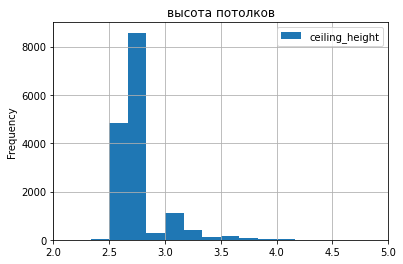

In [36]:
data.plot(title='высота потолков',
          kind='hist', 
          y='ceiling_height',
          bins=30,
          grid=True,
          xlim=(2,5))

**Вывод** Квартиры продаются в основном с потолками от 2,5 – 3 метров. 2,7 самая крупная группа скорее всего это связанно с тем, что пропуски заполнялись средним значением поэтому это могло привести к увеличению этой группы. 

<AxesSubplot:title={'center':'этаж'}, ylabel='Frequency'>

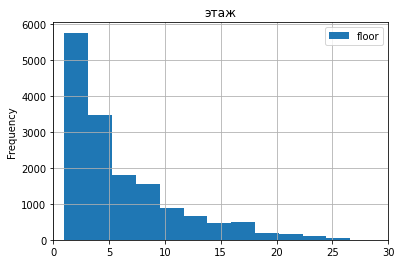

In [37]:
data.plot(title='этаж',
          kind='hist', 
          y='floor',
          bins=15,
          grid=True,
          xlim=(0,30))

**Вывод** В основном квартиры расположены до 10 этажа. Это говорит об общей тенденции что дома не высокие. 

<AxesSubplot:title={'center':'всего этажей в доме'}, ylabel='Frequency'>

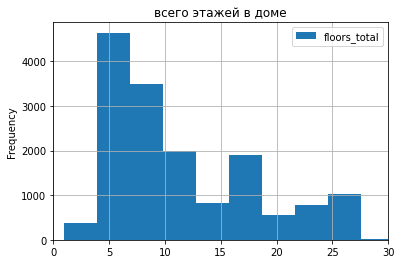

In [38]:
data.plot(title='всего этажей в доме',
          kind='hist', 
          y='floors_total',
          bins=20,
          grid=True,
          xlim=(0,30))

**Вывод** Еще один аргумент в подтверждение привядшего графика. Петербург не славиться высокими дамами что, собственно, и отображает график. Максимальная высота чуть больше 20 этажей 

<AxesSubplot:title={'center':'Расстояние до центра города'}, ylabel='Frequency'>

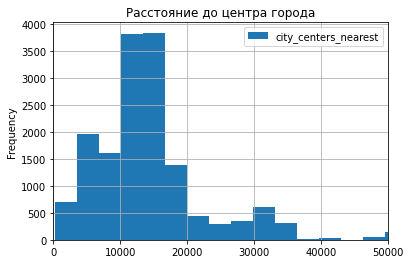

In [39]:
data.plot(title='Расстояние до центра города',
          kind='hist', 
          y='city_centers_nearest',
          bins=20,
          grid=True,
          xlim=(0, 50000))

**Вывод** В основном недвижимость расположена на расстоянии от 5 000 до 20 000 метров от центра города. Но также присутствуют пригородные дома, но их значительно меньше 

<AxesSubplot:title={'center':'Расстояние до аэропорта  '}, ylabel='Frequency'>

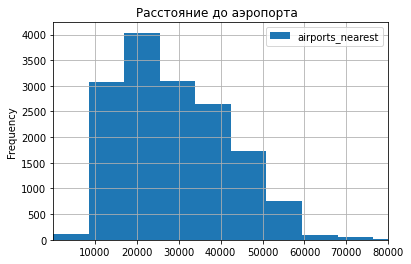

In [40]:
data.plot(title='Расстояние до аэропорта  ',
          kind='hist', 
          y='airports_nearest',
          bins=10,
          grid=True,
          xlim=(100, 80000))

**Вывод** В основном вся недвижимость находиться в средней доступности до аэропорта, т.к. большая часть объявлений расположена в центре города. Те дома, которые расположены в пригороде имеют более дальнее расположение. 

<AxesSubplot:title={'center':'Расположение парка в радиусе 3 000 м'}, ylabel='Frequency'>

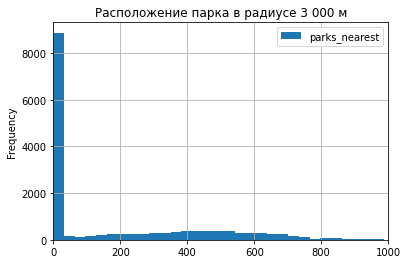

In [41]:
data.plot(title='Расположение парка в радиусе 3 000 м',
          kind='hist', 
          y='parks_nearest',
          bins=100,
          grid=True,
          xlim=(0, 1000))

**Вывод** Из графика видно, в основном парковых зон нет в окружении домов или их не указывают.

<AxesSubplot:title={'center':'день недели'}, ylabel='Frequency'>

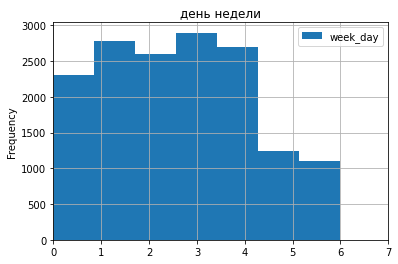

In [42]:
data.plot(title='день недели',
          kind='hist', 
          y='week_day',
          bins=7,
          grid=True,
          xlim=(0, 7))

**Вывод** достаточно интересная динамика. В основном публикации происходят в начале и в середине недели. Под конец недели на 50% меньше публикаций. А в воскресение вообще никаких объявлений не публикуют.

<AxesSubplot:title={'center':'месяц'}, ylabel='Frequency'>

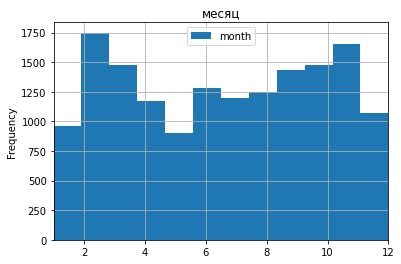

In [43]:
data.plot(title='месяц',
          kind='hist', 
          y='month',
          bins=12,
          grid=True,
          xlim=(1, 12)) 

**Вывод** В принципе график публикаций по месяцам достаточно равномерный +-250 объявлений колеблется. Но самая активная публикационная активность прослеживается в начале года и в конце. 

**Проведение исследовательского анализа данных**

**Анализ продаж квартир**
Данный параметр показывает, сколько дней «висело» каждое объявление.

<AxesSubplot:ylabel='Frequency'>

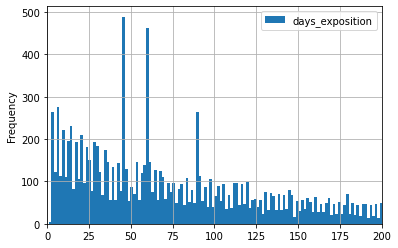

In [44]:
df.plot(kind='hist', 
       y='days_exposition',
       bins=1000,
       grid=True,
       xlim=(0, 200))


In [45]:
(
    df
 .groupby('days_exposition').count()
 .sort_values(by='total_images', ascending=False)
 .head()
)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around_3000,ponds_nearest,price_area,week_day,day,month,year,floor_type,city_centers_nearest_km
days_exposition,,,,,,,,,,,,,,,,,,,,,
60.0,462,462,462,462,462,462,462,298,462,462,...,462,462,462,462,462,462,462,462,462,462
45.0,422,422,422,422,422,422,422,296,422,422,...,422,422,422,422,422,422,422,422,422,422
90.0,184,184,184,184,184,184,184,124,184,184,...,184,184,184,184,184,184,184,184,184,184
30.0,184,184,184,184,184,184,184,181,184,184,...,184,184,184,184,184,184,184,184,184,184
7.0,179,179,179,179,179,179,179,168,179,179,...,179,179,179,179,179,179,179,179,179,179


In [46]:
df.query('days_exposition==60')
         

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around_3000,ponds_nearest,days_exposition,price_area,week_day,day,month,year,floor_type,city_centers_nearest_km
56,3,4500000,80.5,2018-01-15,3,2.67,25,NaN,16,False,...,0.0,0.0,60.0,55900.6,0,15,1,2018,другой,18.0
71,12,4900000,32.0,2018-01-07,1,2.67,25,15.0,5,False,...,1.0,464.0,60.0,153125.0,6,7,1,2018,другой,16.0
80,8,4500000,31.0,2019-02-24,1,2.50,9,17.0,4,False,...,2.0,439.0,60.0,145161.3,6,24,2,2019,другой,9.0
95,9,2990000,30.0,2016-06-08,1,2.50,9,20.0,9,False,...,1.0,332.0,60.0,99666.7,2,8,6,2016,последний,6.0
222,3,5496074,48.6,2016-04-25,1,2.67,11,13.0,3,False,...,1.0,433.0,60.0,113087.9,0,25,4,2016,другой,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15550,10,3750000,45.0,2016-06-14,2,2.67,5,30.0,1,False,...,0.0,0.0,60.0,83333.3,1,14,6,2016,первый,32.0
15566,8,8700000,132.0,2018-11-13,3,2.65,9,78.0,3,False,...,0.0,0.0,60.0,65909.1,1,13,11,2018,другой,18.0
15585,11,5000000,37.9,2017-08-31,1,2.60,21,18.9,14,False,...,0.0,0.0,60.0,131926.1,3,31,8,2017,другой,14.0
15594,9,5100000,36.0,2018-10-26,1,2.80,15,18.0,11,False,...,1.0,405.0,60.0,141666.7,4,26,10,2018,другой,12.0


In [47]:
df['days_exposition'].mean()

182.90243746401381

**Длительность продажи квартир:**

<AxesSubplot:xlabel='days_exposition', ylabel='last_price'>

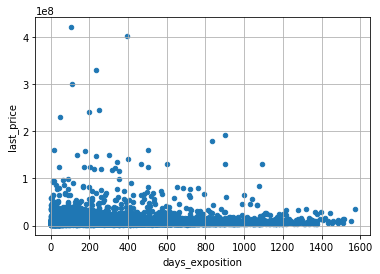

In [48]:
df.plot(kind='scatter', 
        x='days_exposition',
        y='last_price',
        grid=True)

<AxesSubplot:xlabel='days_exposition', ylabel='last_price'>

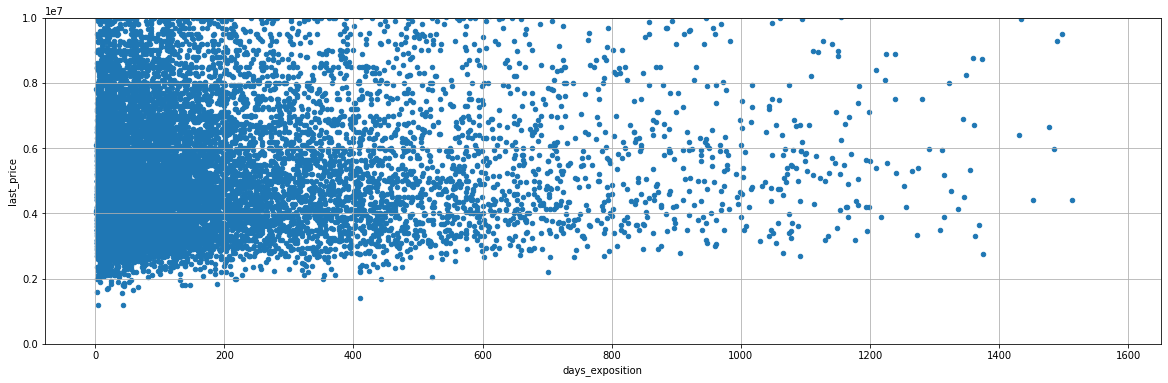

In [49]:
df.plot(kind='scatter', 
        x='days_exposition',
        y='last_price',
        ylim=(0, 10000000), figsize=(20, 6), 
        grid=True)

**Вывод:**
На первом графике видны точки, которые выбиваться из общей группировки, это квартиры выше средней ценовой категории, можно сделать вывод. Что стоимость квартиры не влияет на время продажи другой момент что таких премиальных квартир не много и этот вывод можно подвергнуть сомнению. 

На 2 графике более детально рассмотрена средняя ценовая категория объявлений. Все таки все объявление в большинстве своем продаются за 200 дней 

**Сравним цену недвижимости с количеством дней публикации.**

Квартиры высокой ценовой категории продаются на всем временном диапазоне, другой момент что их не так много. В данных в основном представлена недвижимость до 10 млн. 


In [50]:
print ('медиана', df['days_exposition'].median(), '\n'+'среднее', df['days_exposition'].mean().round(1))

медиана 96.0 
среднее 182.9


**Вывод** Самые быстрыми продажами можно считать квартиры, которые проданы быстрее чем за 100 дней. На них приходиться основное количество это отображено на графике и при расчете медианы (94). Если смотреть среднее значение, то оно выходит слишком завышенным, скорее всего из-за того, что диапазон достаточно большой, а основное скопление продаж происходит в 1/3 графика.

Самые долгие продажи это после 800 дней или 2-х лет. Причем от стоимости квартиры это не зависит

**Факторы влияют на общую (полную) стоимость объекта**

выявление факторов, которые больше всего влияют на общую (полную) стоимость объекта.

        - размер общей площади;
        
        - размер жилой площади;
        
        - площадь кухни;
        
        - количество комнат;
        
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        
        - даты размещения (день недели, месяц, год);

In [51]:
price = df[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 
            'floor_type', 'day', 'month', 'year']]
price.head()

,last_price,total_area,living_area,kitchen_area,rooms,floor_type,day,month,year
0,3350000,40.4,18.6,11.0,1,первый,4,12,2018
1,5196000,56.0,34.3,8.3,2,другой,20,8,2015
2,64900000,159.0,NaN,NaN,3,другой,24,7,2015
3,10000000,100.0,32.0,41.0,2,другой,19,6,2018
4,3700000,37.3,10.6,14.4,1,другой,2,11,2017


<AxesSubplot:xlabel='total_area'>

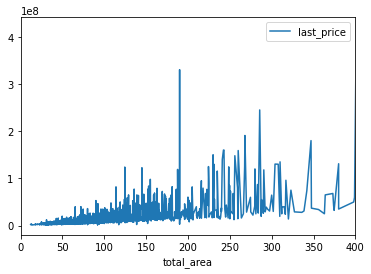

In [52]:
price.sort_values('total_area').plot(x='total_area', y='last_price', xlim=(0, 400))

<AxesSubplot:xlabel='total_area'>

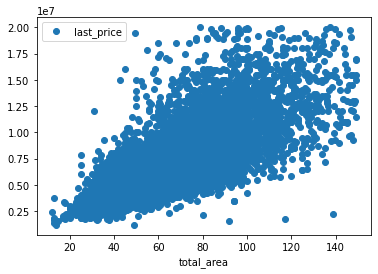

In [53]:
#убираем не подходящие квартиры по цене и площади 
price = price[price['last_price'] < 20000000]  
price = price[price['total_area'] < 150] 

price.sort_values('total_area').plot(style='o', x='total_area', y='last_price')

In [54]:
price['last_price'].corr(price['total_area'])

0.8030360938704262

**Вывод** Для определения зависимости общей площади к цене. Был построен график, по нему стало понятно какие значения можно исключить чтобы они не искажали представление. Визуально прослеживается зависимость чем больше площадь, тем дороже квартира. 

Произведен расчет корреляции и выявлена прямая зависимость размера общей площади к цене

<AxesSubplot:xlabel='living_area'>

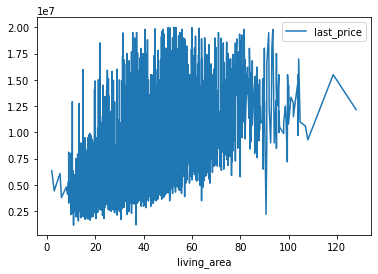

In [55]:
price.sort_values('living_area').plot(x='living_area', y='last_price')

In [56]:
#удаляем выбросы по жилой площади
price = price[price['living_area']<100] 

<AxesSubplot:xlabel='living_area'>

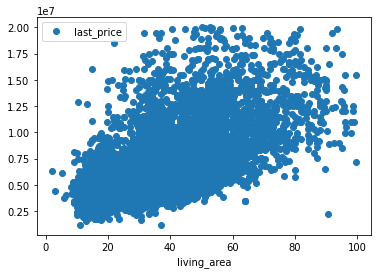

In [57]:
price.plot(style='o', x='living_area', y='last_price')

In [58]:
price['last_price'].corr(price['living_area'])

0.6770198163514708

**Вывод** Взаимосвязь цены от жилой площади не ярко выражена. Об этом нам говорит корреляция между этими факторами 0,67

0.5752733301696596

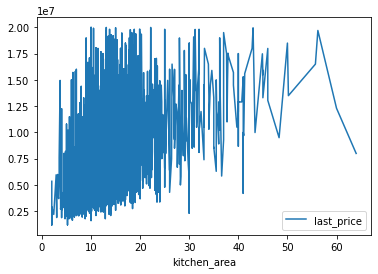

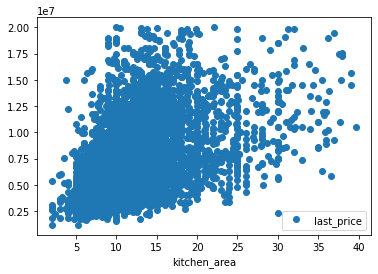

In [59]:
price.sort_values('kitchen_area').plot(x='kitchen_area', y='last_price')

price = price[price['kitchen_area']<40]

price.plot(style='o', x='kitchen_area', y='last_price')

price['last_price'].corr(price['kitchen_area'])

**Вывод** Размер кухни на цену сильно не влияет.

In [60]:
price.groupby('rooms', dropna=False)['last_price'].agg(['count', 'mean'])

,count,mean
rooms,,
1,4767,4.165650e+06
2,4666,5.910739e+06
3,3393,7.403189e+06
4,599,8.714337e+06
5,95,1.084552e+07
6,9,1.058378e+07
7,2,1.350000e+07


**Вывод** Смотрим на основные группы. 1-3 комнатные.
Количество комнат прямо пропорционально влияет на стоимость квартиры 


In [61]:
price.groupby('floor_type', dropna=False)['last_price'].agg(['count', 'mean'])

,count,mean
floor_type,,
другой,10342,5.964160e+06
первый,1481,4.955970e+06
последний,1708,5.800654e+06


**Вывод** Пип этажа не сильно влияет на стоимость. Но квартиры на промежуточном этаже стоят чуть дороже, а квартиры на первом этаже пользуются наименьшим спросом. 

In [62]:
price.groupby('day', dropna=False)['last_price'].agg(['count', 'mean']).sort_values(by='mean')

,count,mean
day,,
6,377,5.521836e+06
7,424,5.543515e+06
31,196,5.612381e+06
5,364,5.620678e+06
22,422,5.623470e+06
14,492,5.652755e+06
17,419,5.655588e+06
30,304,5.660364e+06
2,390,5.662429e+06


**Вывод** Каждый день в месяце публикуется примерно одинаковое количество объявлений, но самые "дешевые" дни 6,7,31,5. Самые "дорогие" дни 10,27,4,20. Итог в начале месяца продаются квартиры дешевле а в конце по дороже. 

In [63]:
price.groupby('month', dropna=False)['last_price'].agg(['mean', 'count'])

,mean,count
month,,
1,5.875560e+06,788
2,5.760325e+06,1491
3,5.853816e+06,1257
4,5.834371e+06,1041
5,5.794868e+06,777
6,5.666477e+06,1110
7,5.725323e+06,1022
8,5.767721e+06,1091
9,6.117859e+06,1291


**Вывод** В начале и в конце года продажи снижаются скорее всего это связано с праздничным периодом. Средняя стоимость продаж на протяжении всего года примерно одинаковая не зависимо от месяца. 

In [64]:
price.groupby('year', dropna=False)['last_price'].agg(['mean', 'count'])

,mean,count
year,,
2014,8.429066e+06,77
2015,6.352753e+06,738
2016,5.897424e+06,1827
2017,5.757934e+06,5421
2018,5.795708e+06,4709
2019,5.679759e+06,759


**Вывод** Основные года публикации это 2016-2018. Средняя стоимость находится на одном уровне, самая большая стоимость в 2014, но и объявлений не много было сделано, скорее всего площадка только запускалась в это время 

**Общий вывод факторов, которые влияют на стоимость.** 
Явные факторы: 


*   общая площадь сильно влияет на стоимость; 
*   количество комнат очень сильно влияет на стоимость так что это важный фактор;
*   жилая площадь тоже влияет, но уже не так сильно, как общая площадь;
*   размер кухни так явно не влияет как вышеперечисленные факторы.
*   месяц размещения, в декабре продаются самые дорогие квартиры

Не сильно влияющие факторы на стоимость:
*   тип этажа;
*   День размещения,
*   Год 


*Результаты указаны в порядке приоритета влияния на цену

"Cредняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name."

сортировка `df` по населенным пунктам

In [65]:
pregorod = df.query('locality_name.str.match("посёлок")')
pregorod_10 = (pregorod.groupby(by='locality_name')[['day']]
               .count()
               .sort_values(by='day', ascending = False)
               .head(10))

Сортировка пригородов с наибольшим числом объявлений. Добавление в таблицу столбца со среднец ценой за 2м к каждому пригороду

In [66]:
prise = []
for pregorod in pregorod_10.index:
  price_area = df[df['locality_name']==pregorod]
  price_area = price_area['last_price'].mean() / price_area['total_area'].mean()
  prise.append(price_area)
    
pregorod_10['prise_mean'] = prise

In [67]:
pregorod_10.sort_values(by='prise_mean').head()#самый дешевый 2м

,day,prise_mean
locality_name,,
посёлок Сапёрный,5,66721.824687
посёлок Понтонный,17,70093.590471
посёлок Металлострой,61,71676.410196
посёлок Молодёжное,3,74983.187626
посёлок Шушары,401,75371.156901


In [68]:
pregorod_10.sort_values(by='prise_mean',ascending =False).head()#самый дорогой 2м

,day,prise_mean
locality_name,,
посёлок Лисий Нос,3,103202.995008
посёлок Стрельна,37,88821.929729
посёлок Парголово,298,86458.765473
посёлок Песочный,4,77863.577864
посёлок Репино,3,76067.044534


**Вывод** Было отобрано 10 самых популярных населенных пунктов. И для каждого рассчитана средняя площадь. Чем меньше количество объявлений, тем сильнее цена отклоняется от среднего значения. Самый дешевый 2м в посёлке Сапёрный 66721.82 при 5 объявлениях. 

Самый дорогой 2м посёлок Лисий Нос 103202.99 при 3 объявлениях. 

Как мы видим, если смотреть на крайние значения они выходят излишне искаженными. Всё-таки надо делать акцент и на количестве объявлений.


## **"Влияние расстояния от центра города на стоимость квартир в городе Санкт-Петербурге "**

Вычисление средней цены каждого километра. Представить описание стоимости объектов в зависимости от расстояния до центра города.

In [69]:
#Сортировка по нужной локации 
sp = df[df['locality_name'] == 'Санкт-Петербург'] 

Чтобы сгруппировать данные, пришлось округлить расстояние от центра города, чтобы были общие группы у квартир на +- одинаковом расстоянии. 

s.p. правда к процессу округления есть вопросы. Но создать группы для общего представления это позволило.

In [70]:
sp_kme = sp.groupby('city_centers_nearest_km')['last_price'].agg([ 'mean', 'count']) #сводная таблица по расстоянию в км 
sp_kme

,mean,count
city_centers_nearest_km,,
0.0,3.037803e+07,19
1.0,1.907091e+07,163
2.0,1.772749e+07,255
3.0,1.041798e+07,273
4.0,1.193870e+07,574
5.0,1.381438e+07,772
6.0,1.482024e+07,516
7.0,1.393945e+07,346
8.0,9.490230e+06,506


<AxesSubplot:xlabel='city_centers_nearest_km'>

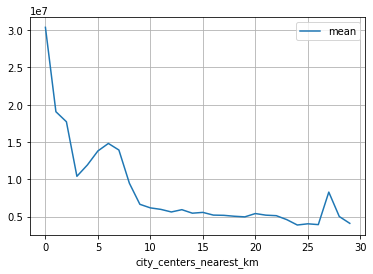

In [71]:
sp_kme.plot(y='mean', grid=True)

In [72]:
sp['last_price'].corr(sp['city_centers_nearest_km'])

-0.2726553999272542

**Вывод** Средняя цена от расстояния достаточно сильно зависит это визуально отображено на графике кривой. Чем ближе к центру, тем больше стоимостью. На графике видно, что в пределах 10 к присутствует недвижимость выше средней цены. Дальше идет снижение по цене, но в основном основное количество объявлений находиться на расстоянии от центра 11-17 км.
корреляция не показала зависимость цены от расстояния, скорее всего это связано с тем что основное количество данных находиться на среднем расстоянии от центра. 

# Общий вывод

В данной работе было проведено исследование о продаже квартир
**Запуск файла CSV**

**Предобработка данных**

Первостепенно для работы с документом была проведена пред обработка данных в нее вошло: приведение столбцов к единому стилю, заполнение необходимых пропусков, исключение аномалий (это делалось на протяжении всей работы), приведение к одному типу данных в столбцах, выявление не явных дубликатов, исправление форматы даты. После этого с данными уже стало возможно работать.

**Добавлены в таблицу новые столбцы**

В таблицу были Внесены промежуточные столбцы для сравнения: цена квадратного метра (от 15000 до 1000000 и более), столбцы с датами, тип этажа (больше всего квартир в типе «другой»), расстояние до центра (отправная точка Питер). 

**Проведен исследовательский анализ данных**

Создана промежуточная таблица для дальнейшего анализа различных данных, как они влияют на стоимость. Проведена отчистка от выбросов. Построены графики различных критериев, которые влияют на стоимость жилья.

Проведен анализ продаж квартир, в результате которого был установлено что среднее время продаж квартир составляет 182 дня, а медиана 96 дней лучше стоит ориентироваться на медиану. Потому что она более корректно отражает ситуацию в данных. Стоимость квартиры не влияет, дорогие квартиры продаются на всем временном лаге. 

Проведен анализ факторов, которые больше всего влияют на стоимость: общая площадь\жилая, количество комнат, размер кухни, время размещения объявления.

Рассчитана средняя цена квадратного метра самый дешевый 2м = 66700, самый дешевый 2м = 103200

Произведен расчет стоимости квартир от расстояния от центра города. Самые дорогие квартиры расположены в центре города до 8 км имеют стоимость от 10 млн. Все объявления дальше 8 км имеют одинаковую среднюю стоимость 5,5 млн. 

**Рекомендации**

Хотелось бы по рекомендовать оптимизировать сайт, на котором происходит заполнение объявлений, потому что в результате не заполненных полей пользователей образуется в таблице достаточно много пропусков. 
Не исключено что если ввести такой жесткий контроль заполнения объявления, то и мошенникам станет сложнее создавать фейковые объявления. 

Так же повысить контроль идентификации пользователя перед размещением объявления. Это тоже поможет сократить анонимность.


**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод